In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk import pos_tag
from nltk import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, plot_confusion_matrix

from sklearn.pipeline import make_pipeline , Pipeline

In [26]:
from collections import Counter
sw = stopwords.words('english')

In [29]:
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()

#### Load Dataframe

In [3]:
df = pd.read_csv('data/judge-1377884607_tweet_product_company.csv',encoding='latin1')

#### Rename columns for simplicity

In [4]:
df.shape

(9093, 3)

In [5]:
df.rename(columns = {'emotion_in_tweet_is_directed_at': 'Product', 'is_there_an_emotion_directed_at_a_brand_or_product': 'Emotion', 'tweet_text': 'Tweet'}, inplace= True)

In [6]:
df.drop(9092, inplace=True)
df.reset_index(drop=True, inplace=True)

#### LowerCase tweets for ease of use

In [7]:
df['Text'] = df['Tweet'].str.lower()
df['Text'] = df['Text'].str.replace(r'[^\w\s]', '')
df['Text'] = df['Text'].str.split(' ')

In [8]:
df.dropna(subset=['Text'], inplace=True)

In [9]:
df['Product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: Product, dtype: int64

In [10]:
df['test'] = ''
df.fillna('na', inplace=True)

In [11]:
apple_keywords = ['apple', '#apple', 'ipad', '#ipad', '#iphone', 'iphone', 'itunes', '#itunes', 'ios', 'airpods', '#ios', '#airpods'
                 'iphones', 'ipads', 'apples', 'quotapple', 'quotipad', 'ipadquot', 'quotipads', 'ipadsquot', 'applequot', 'quotiphone', 'iphonequot', 'quotios', 'iosquot', 'quotiphones', 'iphonesquot', 'ipad2']
google_keywords = ['google', '#google', 'android', '#android', 'googles', 'androids', 'quotgoogle', 'googlequot', 'quotandroid', 'androidquot', 'quotandroids', 'androidsquot' ]

for ind, val in enumerate(df['Text']):
    if df['Product'].values[ind] == 'na':
        for y in val:
            if y in apple_keywords:
                df['test'].values[ind] = y
            elif y in google_keywords:
                df['test'].values[ind] = y
                
    else:
        df['test'].values[ind] = df['Product'].values[ind]


In [12]:
df['test'] = df['test'].map(lambda x: x.lower())
df['test'].unique()

array(['iphone', 'ipad or iphone app', 'ipad', 'google', 'android',
       'apple', 'android app', 'other google product or service',
       'itunes', '', 'quotgoogle', 'ipad2', 'googles', 'ipads',
       'applequot', 'ios', 'apples', 'ipadquot',
       'other apple product or service', 'quotipad', 'iosquot',
       'quotiphone', 'androidquot', 'googlequot', 'quotapple', 'androids',
       'iphonequot'], dtype=object)

In [13]:
df['test'] = df['test'].replace({'googles': 'google', 'apples': 'apple', 'androids': 'android','ipads': 'ipad', 'ipad2': 'ipad',
                                'quotgoogle': 'google', 'ipadquot': 'ipad', 'quotipad': 'ipad', 'androidquot': 'android', 'applequot': 'apple',
                               'googlequot': 'google', 'iphonequot': 'iphone', 'quotapple' : 'apple', 'iosquot': 'ios', 'quotiphone': 'iphone',
                                '#ipad' : 'ipad', '#google' : 'google', '#android': 'android', '#apple': 'apple', '#iphone': 'iphone'})
df['test'].unique()

array(['iphone', 'ipad or iphone app', 'ipad', 'google', 'android',
       'apple', 'android app', 'other google product or service',
       'itunes', '', 'ios', 'other apple product or service'],
      dtype=object)

In [14]:
emotion_dict = {'No emotion toward brand or product' : 'Neutral emotion', "I can't tell": 'Neutral emotion', 'Positive emotion': 'Positive emotion',
               'Negative emotion': 'Negative emotion'}
df['Emotion'] = df['Emotion'].map(emotion_dict)

In [15]:
df['Emotion'].value_counts(normalize=True)

Neutral emotion     0.609724
Positive emotion    0.327577
Negative emotion    0.062699
Name: Emotion, dtype: float64

In [16]:
df['test'].value_counts()

ipad                               2286
google                             2087
apple                              1496
iphone                             1052
                                    840
ipad or iphone app                  470
android                             379
other google product or service     293
android app                          81
itunes                               64
other apple product or service       35
ios                                   8
Name: test, dtype: int64

In [17]:
def company_search(test):
    if test == 'iphone':
        return 'apple'
    elif test == 'apple':
        return 'apple'
    elif test == 'ipad':
        return 'apple'
    elif test == 'ipad or iphone app':
        return 'apple'
    elif test == 'itunes':
        return 'apple'
    elif test == 'other apple product or service':
        return 'apple'
    elif test == 'ios':
        return 'apple'
    elif test == 'ipadquot':
        return 'apple'
    elif test == 'applequot':
        return 'apple'
    elif test == 'iphonequot':
        return 'apple'
    elif test == 'quotiphone':
        return 'apple'
    elif test == 'iosquot':
        return 'apple'
    elif test =='quotipad':
        return 'apple'
    elif test == 'quotapple':
        return 'apple'
    elif test =='google':
        return 'google'
    elif test == 'android':
        return 'google'
    elif test == 'other google product or service':
        return 'google'
    elif test == 'android app':
        return 'google'
    elif test == 'quotgoogle':
        return 'google'
    elif test == 'googlequot':
        return 'google'
    elif test == 'androidquot':
        return 'google'
    else:
        return 'unknown'

In [18]:
df['company'] = df['test'].apply(company_search)

In [19]:
df['company'].value_counts()

apple      5411
google     2840
unknown     840
Name: company, dtype: int64

In [20]:
from nltk.tokenize import TweetTokenizer
ttokenize = TweetTokenizer(preserve_case=False, reduce_len=False)

In [21]:
import re

In [22]:
df['clean_tweet'] = [re.sub(r'(http://[^"\s]+)|(@\w+)', '', tweet)
                           for tweet in df['Tweet']]

In [23]:
df['clean_tweet'] = df['Tweet'].str.replace(r'[^\w\s]', '')

In [27]:
def clean_tweet(tweet):
    token = ttokenize.tokenize(tweet)
    tokens = [word.lower() for word in token]
    no_sw = [word for word in tokens if word not in sw]
    lemmad = [lemma.lemmatize(word) for word in no_sw]
    return lemmad
    

In [30]:
df['clean_tweet'] = df['clean_tweet'].apply(clean_tweet)

### Add Target values


In [31]:
target_dict = {'Negative emotion': 0, 'Neutral emotion': 1, 'Positive emotion': 2}
df['target'] = df['Emotion'].map(target_dict)

In [32]:
df['target'].value_counts()

1    5543
2    2978
0     570
Name: target, dtype: int64

#### Seperate Dataframes by company

In [33]:
df_apple = df.loc[df['company'] == 'apple']
df_google = df.loc[df['company'] == 'google']


#### Seperate Dataframes by tweet sentiment

In [34]:
df_pos = df.loc[df.target == 2]
df_neg = df.loc[df.target == 0]
df_neutral = df.loc[df.target == 1]

#### Lists/Dictionary of words used in pos/neg/neutral tweets

In [35]:
pos_words = []
neg_words = []
neutral_words = []

for list_ in df_pos['Text']:
    for word in list_:
        pos_words.append(word)

        
for list_ in df_neg['Text']:
    for word in list_:
        neg_words.append(word)
        
        
for list_ in df_neutral['Text']:
    for word in list_:
        neutral_words.append(word)
    

In [38]:
pos_words = [lemma.lemmatize(word) for word in pos_words if word not in sw]
neg_words = [lemma.lemmatize(word) for word in neg_words if word not in sw]
neutral_words =  [lemma.lemmatize(word) for word in neutral_words if word not in sw]



In [39]:
pos_dict = Counter(pos_words)
neg_dict = Counter(neg_words)
neutral_dict = Counter(neutral_words)

In [40]:
pos_dict = dict(sorted(pos_dict.items(), key=lambda item: item[1], reverse=True))
neg_dict = dict(sorted(neg_dict.items(), key=lambda item: item[1], reverse=True))
neutral_dict = dict(sorted(neutral_dict.items(), key=lambda item: item[1], reverse=True))

In [41]:
pos_dict.pop('')
neg_dict.pop('')
neutral_dict.pop('')

2098

In [31]:
dict(list(pos_dict.items())[0:20])

{'sxsw': 3068,
 'mention': 2113,
 'link': 1206,
 'ipad': 982,
 'rt': 922,
 'apple': 875,
 'google': 690,
 'store': 549,
 'iphone': 520,
 '2': 497,
 'app': 391,
 'new': 359,
 'austin': 292,
 'popup': 218,
 'ipad2': 202,
 'android': 198,
 'amp': 181,
 'get': 181,
 'launch': 174,
 'one': 148}

In [32]:
dict(list(neg_dict.items())[0:20])

{'sxsw': 578,
 'mention': 301,
 'ipad': 181,
 'iphone': 155,
 'google': 141,
 'rt': 137,
 'apple': 106,
 'link': 101,
 '2': 65,
 'app': 60,
 'store': 45,
 'new': 43,
 'like': 42,
 'circle': 36,
 'need': 35,
 'social': 30,
 'apps': 30,
 'people': 29,
 'design': 28,
 'get': 25}

#### Adding common words used in both positive and negative tweets to stopwords list

In [36]:
common_words = ['sxsw', 'mention', 'link', 'ipad', 'iphone', 'google', 'apple', '2', 'android', 'rt']


In [37]:
sw.extend(common_words)

## Visualizations

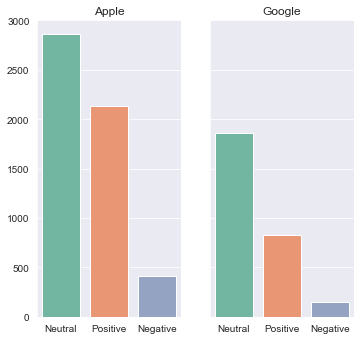

In [99]:
plt.figure(figsize=(15, 12))

sns.set_style('darkgrid')


ax1 = plt.subplot2grid(shape=(2,5), loc = (0,0))
ax2 = plt.subplot2grid(shape=(2,5), loc = (0,1),)

sns.barplot(x = df_apple['Emotion'].value_counts().index,
           y = df_apple['Emotion'].value_counts().values,
           ax =ax1)
ax1.set_xticklabels(['Neutral', 'Positive', 'Negative'])
ax1.set_title('Apple')
ax1.set_ylim(0,3000)

sns.barplot(x = df_google['Emotion'].value_counts().index,
           y = df_google['Emotion'].value_counts().values,
           ax = ax2)
ax2.set_xticklabels(['Neutral', 'Positive', 'Negative'])
ax2.set_title('Google')
ax2.set_ylim(0,3000)
ax2.set(yticklabels = []);

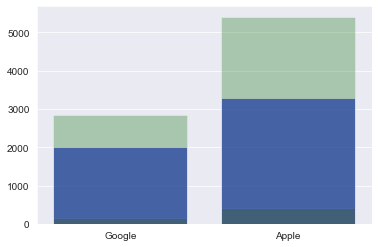

In [110]:
bar1 = sns.barplot(x = ['Google', 'Apple'], y = [152, 415], color='yellow')
bar2 = sns.barplot(x = ['Google', 'Apple'], y = [152+1856, 415+2864], color='blue', alpha=.7)
bar3 = sns.barplot(x = ['Google', 'Apple'], y = [152+1856+832, 415+2864+2132], color='green', alpha=.3)



In [91]:
total = df.groupby(['company', 'Emotion']).count()

total

Tweet  Product  Text  test  clean_tweet  target  \
company Emotion                                                             
apple   Negative emotion    415      415   415   415          415     415   
        Neutral emotion    2864     2864  2864  2864         2864    2864   
        Positive emotion   2132     2132  2132  2132         2132    2132   
google  Negative emotion    152      152   152   152          152     152   
        Neutral emotion    1856     1856  1856  1856         1856    1856   
        Positive emotion    832      832   832   832          832     832   
unknown Negative emotion      3        3     3     3            3       3   
        Neutral emotion     823      823   823   823          823     823   
        Positive emotion     14       14    14    14           14      14   

                          category  
company Emotion                     
apple   Negative emotion       415  
        Neutral emotion       2864  
        Positive emotion      2132  
google  Negative emotion       152  
        Neutral emotion       1856  
        Positive emotion       832  
unknown Negative emotion         0  
        Neutral emotion          0  
        Positive emotion         0

<AxesSubplot:>

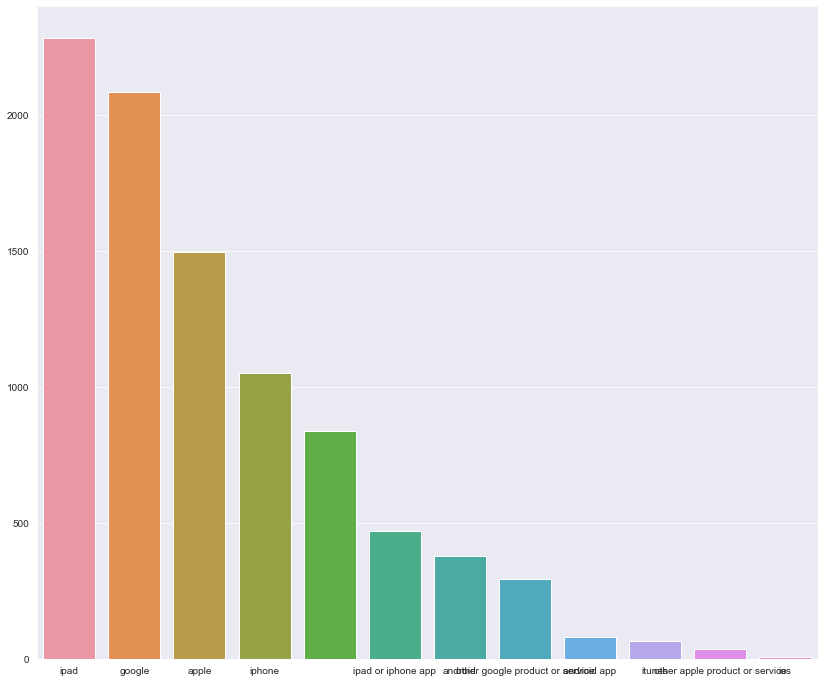

In [47]:
plt.figure(figsize=(14,12))



sns.barplot(x = df['test'].value_counts().index,
           y = df['test'].value_counts().values)

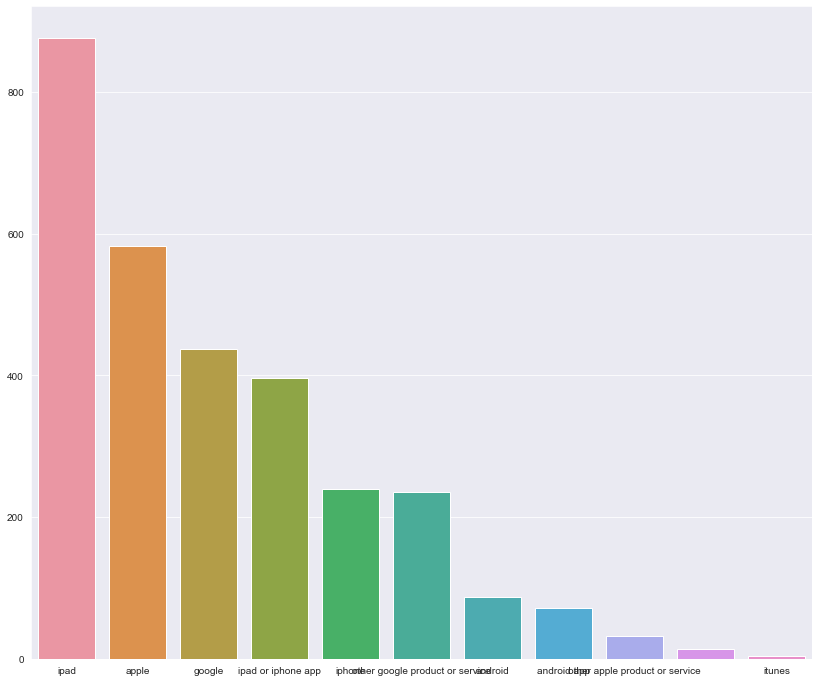

In [44]:
plt.figure(figsize=(14,12))

sns.set_style('darkgrid')

sns.barplot(x = df_pos['test'].value_counts().index,
           y = df_pos['test'].value_counts().values);

<AxesSubplot:>

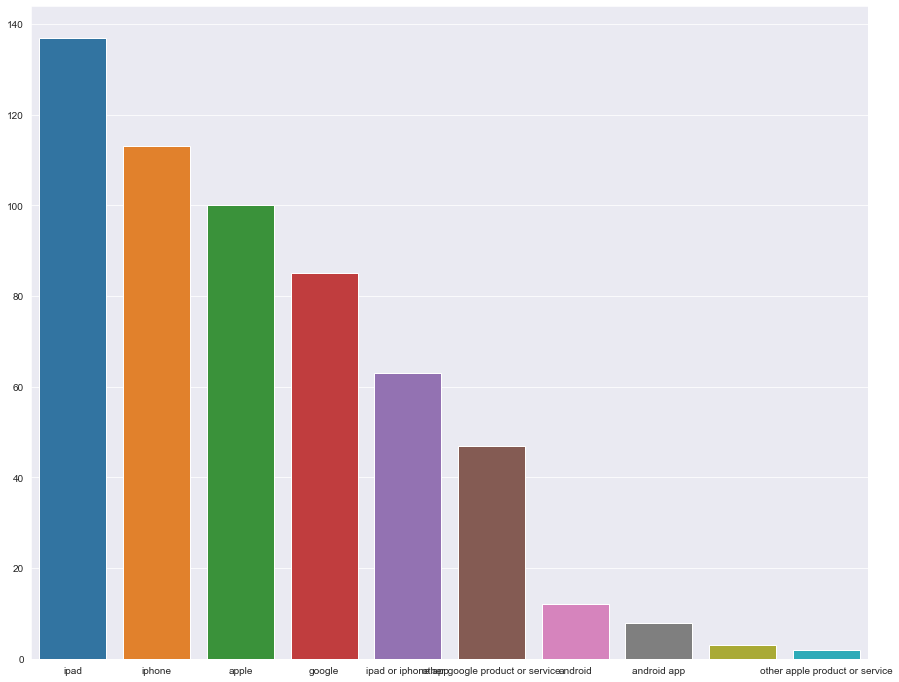

In [134]:
plt.figure(figsize=(15,12))

sns.barplot(x = df_neg['test'].value_counts().index,
           y = df_neg['test'].value_counts().values)

In [46]:
cat_dict = {'iphone' : 'Phone/iPad', 'android': 'Phone/iPad', 'ipad': 'Phone/iPad', 'apple':'Platform',
'google':'Platform', 'ipad or iphone app': 'App', 'android app': 'App', 'other google product or service' : 'Other product/service',
'other apple product or service': 'Other product/service', 'ios': 'Other product/service', 'itunes': 'Other product/service'}


In [47]:
df['category'] = df['test'].map(cat_dict)

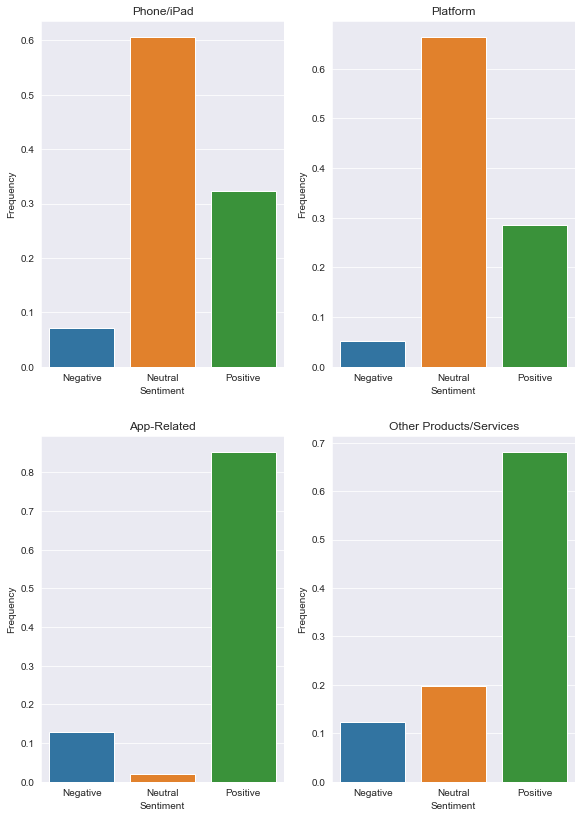

In [48]:
plt.figure(figsize=(20,14))

ax1 = plt.subplot2grid(shape=(2,4), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,4), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,4), loc=(1,0))
ax4 = plt.subplot2grid(shape=(2,4), loc=(1,1))

sns.barplot(x = df.loc[df.category == 'Phone/iPad']['target'].value_counts().index,
               y = df.loc[df.category == 'Phone/iPad']['target'].value_counts(normalize=True),
           ax=ax1)
ax1.set_title('Phone/iPad')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.category == 'Platform']['target'].value_counts().index,
            y = df.loc[df.category == 'Platform']['target'].value_counts(normalize=True),
           ax=ax2)
ax2.set_title('Platform')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Frequency')
ax2.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.category == 'App']['target'].value_counts().index,
               y = df.loc[df.category == 'App']['target'].value_counts(normalize=True),
           ax=ax3)
ax3.set_title('App-Related')
ax3.set_xlabel('Sentiment')
ax3.set_ylabel('Frequency')
ax3.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.category == 'Other product/service']['target'].value_counts().index,
               y = df.loc[df.category == 'Other product/service']['target'].value_counts(normalize=True),
           ax=ax4)
ax4.set_title('Other Products/Services')
ax4.set_xlabel('Sentiment')
ax4.set_ylabel('Frequency')
ax4.set_xticklabels(['Negative', 'Neutral', 'Positive']);

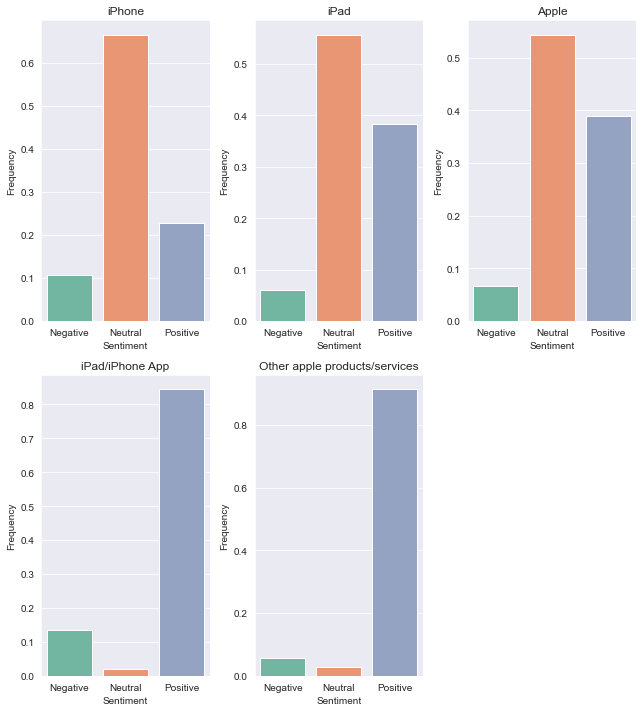

In [49]:
plt.figure(figsize=(12,10))

ax1 = plt.subplot2grid(shape=(2,4), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,4), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,4), loc=(1,0))
ax4 = plt.subplot2grid(shape=(2,4), loc=(1,1))
ax5 = plt.subplot2grid(shape=(2,4), loc=(0,2))

sns.set_palette('Set2')

sns.barplot(x = df.loc[df.test == 'iphone']['target'].value_counts().index,
               y = df.loc[df.test == 'iphone']['target'].value_counts(normalize=True),
           ax=ax1)
ax1.set_title('iPhone')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.test == 'ipad']['target'].value_counts().index,
           y = df.loc[df.test == 'ipad']['target'].value_counts(normalize=True),
           ax=ax2)


ax2.set_title('iPad')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Frequency')
ax2.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.test == 'ipad or iphone app']['target'].value_counts().index,
           y = df.loc[df.test == 'ipad or iphone app']['target'].value_counts(normalize=True),
           ax=ax3)

ax3.set_title('iPad/iPhone App')
ax3.set_xlabel('Sentiment')
ax3.set_ylabel('Frequency')
ax3.set_xticklabels(['Negative', 'Neutral', 'Positive'])


sns.barplot(x = df.loc[df.test == 'other apple product or service']['target'].value_counts().index,
           y = df.loc[df.test == 'other apple product or service']['target'].value_counts(normalize=True),
           ax=ax4)

ax4.set_title('Other apple products/services')
ax4.set_xlabel('Sentiment')
ax4.set_ylabel('Frequency')
ax4.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.test == 'apple']['target'].value_counts().index,
           y = df.loc[df.test == 'apple']['target'].value_counts(normalize=True),
           ax=ax5)

ax5.set_title('Apple')
ax5.set_xlabel('Sentiment')
ax5.set_ylabel('Frequency')
ax5.set_xticklabels(['Negative', 'Neutral', 'Positive'])


plt.tight_layout()





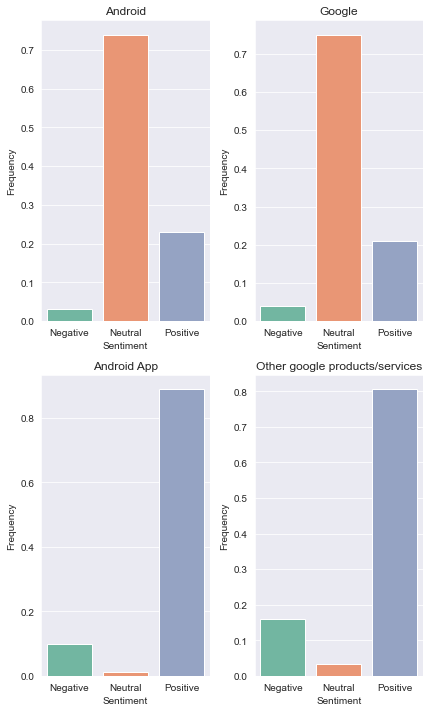

In [50]:
plt.figure(figsize=(12,10))

ax1 = plt.subplot2grid(shape=(2,4), loc=(0,0))
ax2 = plt.subplot2grid(shape=(2,4), loc=(0,1))
ax3 = plt.subplot2grid(shape=(2,4), loc=(1,0))
ax4 = plt.subplot2grid(shape=(2,4), loc=(1,1))

sns.barplot(x = df.loc[df.test == 'android']['target'].value_counts().index,
               y = df.loc[df.test == 'android']['target'].value_counts(normalize=True),
           ax=ax1)
ax1.set_title('Android')
ax1.set_xlabel('Sentiment')
ax1.set_ylabel('Frequency')
ax1.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.test == 'google']['target'].value_counts().index,
           y = df.loc[df.test == 'google']['target'].value_counts(normalize=True),
           ax=ax2)


ax2.set_title('Google')
ax2.set_xlabel('Sentiment')
ax2.set_ylabel('Frequency')
ax2.set_xticklabels(['Negative', 'Neutral', 'Positive'])

sns.barplot(x = df.loc[df.test == 'android app']['target'].value_counts().index,
           y = df.loc[df.test == 'android app']['target'].value_counts(normalize=True),
           ax=ax3)

ax3.set_title('Android App')
ax3.set_xlabel('Sentiment')
ax3.set_ylabel('Frequency')
ax3.set_xticklabels(['Negative', 'Neutral', 'Positive'])


sns.barplot(x = df.loc[df.test == 'other google product or service']['target'].value_counts().index,
           y = df.loc[df.test == 'other google product or service']['target'].value_counts(normalize=True),
           ax=ax4)

ax4.set_title('Other google products/services')
ax4.set_xlabel('Sentiment')
ax4.set_ylabel('Frequency')
ax4.set_xticklabels(['Negative', 'Neutral', 'Positive'])

plt.tight_layout()


In [51]:
app = (df.loc[df.test == 'ipad or iphone app']['Text'])

In [52]:
app_words = []

for list in app:
    for word in list:
        app_words.append(word)
        

In [53]:
app_words_c = Counter(app_words)
app_words_dict = dict(sorted(app_words_c.items(), key=lambda item: item[1], reverse=True))

### Modeling

In [54]:
def metrics(y_true,y_preds):
    '''Gives recall,precision,accuracy,F1 score and confusion matrix'''
    return print(f'''Recall Score: {recall_score(y_true,y_preds,average='micro')}
Precision Score: {precision_score(y_true,y_preds,average='micro')}
Accuracy Score:{accuracy_score(y_true,y_preds)}
F1 Score: {f1_score(y_true,y_preds,average='micro')}
Confusion Matrix: 
{confusion_matrix(y_true,y_preds)}''')
def mean_scores(results):
    '''Return Train/Test Mean Score from a Cross Val'''
    return print(f'''Mean Train Score: {results['train_score'].mean()}
Mean Test Score: {results['test_score'].mean()}''')

In [55]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split , cross_validate , GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [58]:
df_test = df.drop(['Product', 'Emotion', 'company'], axis=1)

#### Train Test Split

In [214]:
X = df_test['clean_tweet'].str.join(' ')
y = df_test.target


In [166]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

### RandomForestClassifier

In [193]:
pipe = make_pipeline(TfidfVectorizer(), RandomForestClassifier())
cv = cross_validate(pipe, X_train, y_train,return_train_score=True)


In [194]:
mean_scores(cv)

Mean Train Score: 0.9675124707704501
Mean Test Score: 0.6855379822411749


### MultinomialNB

In [183]:
pipemnb = make_pipeline(TfidfVectorizer(), MultinomialNB())
cvmnb = cross_validate(pipemnb, X_train, y_train, return_train_score=True)
mean_scores(cvmnb)

Mean Train Score: 0.7672337695119954
Mean Test Score: 0.6635397594146086


### Logistic Regression

In [186]:
pipelr = make_pipeline(TfidfVectorizer(), LogisticRegression())
cvlr = cross_validate(pipelr, X_train, y_train, return_train_score=True)
mean_scores(cvlr)

Mean Train Score: 0.8191919888597475
Mean Test Score: 0.689058657481018


In [369]:
svc_pipe = Pipeline([("count" , TfidfVectorizer()),
                       ("svc", SVC(kernel = 'linear'))])

In [370]:
cv_svc = cross_validate(svc_pipe, X_train, y_train, return_train_score=True)
mean_scores(cv_svc)

Mean Train Score: 0.8484893738380865
Mean Test Score: 0.6925790099896081


### SVC w/ Tfidfvectorizer model

In [191]:
svc = SVC(kernel = 'linear')

In [436]:
svc2 = SVC(kernel='rbf', C=3)

In [196]:
tfidf = TfidfVectorizer()
tfidf_x_tr = tfidf.fit_transform(X_train)
tfidf_x_ts = tfidf.transform(X_test)


In [205]:
svc.fit(tfidf_x_tr, y_train)

SVC(kernel='linear')

In [434]:
svc2.fit(tfidf_x_tr, y_train)

SVC(C=3)

In [200]:
cvsvc = cross_validate(svc, tfidf_x_tr, y_train, return_train_score=True)
mean_scores(cvsvc)

Mean Train Score: 0.848892666840775
Mean Test Score: 0.6956593722231665


In [437]:
cvsvc2 = cross_validate(svc2, tfidf_x_tr, y_train, return_train_score=True)
mean_scores(cvsvc2)

Mean Train Score: 0.9609123148795173
Mean Test Score: 0.6934600663105148


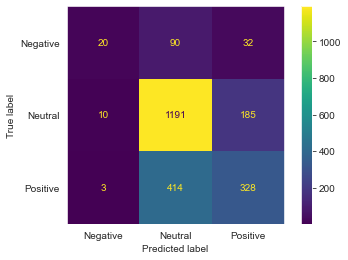

In [430]:
plot_confusion_matrix(svc, tfidf_x_ts, y_test, display_labels = ['Negative', 'Neutral', 'Positive'])
plt.grid(False)

### Tfidf Exploration

In [59]:
raw_pos = []
raw_neg = []
raw_neu = []

pos_tweets = df_test.loc[df.target==2]
pos_tweets

neg_tweets = df_test.loc[df.target==0]

neutral_tweets = df_test.loc[df.target==1]

for listx in pos_tweets.clean_tweet:
    for x in listx:
        raw_pos.append(x)
    
for listx in neg_tweets.clean_tweet:
    for x in listx:
        raw_neg.append(x)
        
for listx in neutral_tweets.clean_tweet:
    for x in listx:
        raw_neu.append(x)

In [60]:
raw_pos = ' '.join(raw_pos)
raw_neg = ' '.join(raw_neg)
raw_neu = ' '.join(raw_neu)

In [61]:
top_poswords = dict(df_topwords.loc[['positive']].max().sort_values(ascending=False)[:150])

NameError: name 'df_topwords' is not defined

In [355]:
top_poswords

{'store': 0.4460859665691307,
 'app': 0.31932929847298425,
 'new': 0.29170284516997796,
 'austin': 0.2372624813081715,
 'popup': 0.17713431823692258,
 'get': 0.1470702367012981,
 'amp': 0.1470702367012981,
 'launch': 0.14138243749185564,
 'one': 0.12025632614249789,
 'party': 0.11456852693305543,
 'line': 0.11456852693305543,
 'time': 0.10969327046781902,
 'great': 0.10969327046781902,
 'via': 0.10644309949099476,
 'social': 0.10075530028155229,
 'free': 0.09913021479314016,
 'cool': 0.09506750107210982,
 'day': 0.09506750107210982,
 'map': 0.09425495832790375,
 'win': 0.09344241558369769,
 'like': 0.09262987283949162,
 'im': 0.09100478735107949,
 'today': 0.09100478735107949,
 'circle': 0.09019224460687342,
 'go': 0.08369190265322489,
 'come': 0.08206681716481275,
 'mobile': 0.08044173167640062,
 'sxswi': 0.07719156069957635,
 'love': 0.07556647521116422,
 'network': 0.07394138972275208,
 'awesome': 0.07312884697854602,
 'temporary': 0.07231630423433995,
 'downtown': 0.071503761490133

In [359]:
top_negwords = dict(df_topwords.loc[['negative']].max().sort_values(ascending=False)[:100])

In [357]:
top_negwords

{'app': 0.3064738766191898,
 'store': 0.22985540746439231,
 'new': 0.219639611577086,
 'like': 0.21453171363343285,
 'circle': 0.18388432597151386,
 'need': 0.1787764280278607,
 'social': 0.1532369383095949,
 'apps': 0.1532369383095949,
 'people': 0.1481290403659417,
 'design': 0.14302114242228856,
 'get': 0.12769744859132906,
 'austin': 0.1225895506476759,
 'time': 0.11748165270402275,
 'think': 0.11748165270402275,
 'one': 0.11748165270402275,
 'look': 0.10726585681671642,
 'launch': 0.10726585681671642,
 'dont': 0.10726585681671642,
 'line': 0.10215795887306325,
 'say': 0.10215795887306325,
 'day': 0.10215795887306325,
 'would': 0.0970500609294101,
 'today': 0.09194216298575693,
 'news': 0.09194216298575693,
 'go': 0.08683426504210377,
 'fail': 0.08683426504210377,
 'phone': 0.08683426504210377,
 'long': 0.08683426504210377,
 'battery': 0.0817263670984506,
 'product': 0.0817263670984506,
 'user': 0.0817263670984506,
 'year': 0.0817263670984506,
 'thing': 0.07661846915479745,
 'heada

In [272]:
word_list = [raw_pos, raw_neg, raw_neu]

In [274]:
df_raw = pd.DataFrame(word_list, index = ['positive', 'negative', 'neutral'], columns = ['raw_text'])

In [282]:
tfidf_raw = TfidfVectorizer(stop_words = sw, max_features=500)
X_raw = tfidf_raw.fit_transform(df_raw.raw_text)
df_topwords = pd.DataFrame(X_raw.toarray(), columns = tfidf_raw.get_feature_names(), index=df_raw.index)

In [481]:
poswords_dict = {}
for word, item in top_poswords.items():
    if word not in top_negwords.keys():
        poswords_dict = {poswords_dict[word]: powe}
        

party 0.11456852693305543
great 0.10969327046781902
free 0.09913021479314016
cool 0.09506750107210982
win 0.09344241558369769
mobile 0.08044173167640062
love 0.07556647521116422
awesome 0.07312884697854602
temporary 0.07231630423433995
downtown 0.07150376149013388
opening 0.07150376149013388
open 0.06662850502489748
got 0.06419087679227928
check 0.06256579130386715
thanks 0.05687799209442468
fun 0.05336113296556119
next 0.04956510739657008
marissa 0.04956510739657008
video 0.04875256465236401
around 0.04875256465236401
begin 0.048129649341486565
pop 0.04712747916395187
make 0.04631493641974581
case 0.04631493641974581
set 0.043064765442921545
shop 0.04225222269871547
tech 0.04225222269871547
nice 0.04062713721030334
smart 0.039814594466097274
game 0.03900205172189121
technology 0.03900205172189121
music 0.03871297881815224
using 0.03818950897768514
team 0.03818950897768514
panel 0.03656442348927301
big 0.03656442348927301
marketing 0.03412679525665481
wow 0.03412679525665481
week 0.034

{'ready': 0.024376282326182004}

In [398]:
for word, item in top_negwords.items():
    if word not in top_poswords.keys():
        print(word, item)

fail 0.08683426504210377
long 0.08683426504210377
battery 0.0817263670984506
headache 0.07661846915479745
much 0.07661846915479745
company 0.07661846915479745
ive 0.07661846915479745
money 0.07151057121114428
doesnt 0.06640267326749112
many 0.06640267326749112
room 0.06640267326749112
yet 0.06129477532383795
back 0.06129477532383795
fast 0.06129477532383795
already 0.06129477532383795
tapworthy 0.06129477532383795
twitter 0.05618687738018479
instead 0.05618687738018479
japan 0.05618687738018479
quoti 0.05618687738018479
gave 0.05107897943653163
blackberry 0.05107897943653163
bing 0.05107897943653163
nothing 0.05107897943653163
content 0.05107897943653163
made 0.05107897943653163
didnt 0.045971081492878464
diller 0.045971081492878464
another 0.045971081492878464
weekend 0.045971081492878464


In [313]:
pd.set_option('display.max_colwidth', None)

In [221]:
df_test['body'] = df_test['clean_tweet'].str.join(' ')

In [232]:
tf_vec = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)", stop_words=sw)
X_tfv = tf_vec.fit_transform(df_test.body)

df_tfv = pd.DataFrame(X_tfv.toarray(), columns=tf_vec.get_feature_names())
df_tfv.head()



,aapl,aaron,aarpbulletin,ab,abacus,abandoned,abba,abc,aber,ability,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_tfv(columns)

In [242]:
df_tfv_sums = df_tfv.append(df_tfv.sum(numeric_only=True), ignore_index=True)

In [243]:
df_tfv_sums.tail()

,aapl,aaron,aarpbulletin,ab,abacus,abandoned,abba,abc,aber,ability,...,zlf,zms,zomb,zombie,zomg,zone,zoom,zuckerberg,zynga,zzzs
9087,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9088,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9089,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9090,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
9091,4.649007,0.705112,0.935498,3.874814,0.741375,0.4283,0.585132,2.104779,0.407726,1.51783,...,5.978721,0.852745,4.638374,2.564003,2.923855,1.06909,1.050605,1.190754,1.452015,0.380383


In [248]:
df_tfv_sums.iloc[9091].sort_values(ascending=False)

store       295.261359
new         208.971155
austin      200.387100
launch      171.774050
circle      165.308805
               ...    
primo         0.221553
visto         0.221553
os            0.221553
lexpress      0.221553
nowhere       0.221553
Name: 9091, Length: 9510, dtype: float64

In [237]:
df_tfv.max().sort_values(ascending=False)[:25]

circle          1.000000
austin          1.000000
partyawesome    1.000000
rock            1.000000
take            1.000000
taken           1.000000
worship         1.000000
dev             1.000000
everywhere      1.000000
hmmmm           1.000000
screen          1.000000
line            1.000000
charging        1.000000
lazy            1.000000
traveling       1.000000
texas           1.000000
spot            1.000000
check           1.000000
haha            1.000000
doodle          1.000000
store           1.000000
heart           1.000000
watch           1.000000
location        0.971965
soo             0.954119
dtype: float64

In [235]:
df_tfv.loc[df_tfv.rock == 1]['rock']

1717    1.0
Name: rock, dtype: float64

In [244]:
df_test.Tweet.iloc[1717]

'@mention #SXSW iPad rocks'

### Neural Network Attempt

In [443]:
from gensim.models import word2vec
from nltk import word_tokenize
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras import regularizers
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [447]:
y_nn = df_test['target']
x_nn = df_test['body']

In [456]:
type(x_nn)

pandas.core.series.Series

In [457]:
def clean_string(text):
    clean_text = text.replace("[",'').replace("]",'').replace("'",'').replace(",",'')
    return clean_text

x_nn = x_nn.to_list()

In [450]:
words = x_nn
words_list = []

for string_ele in words:
    split_up_words = string_ele.split()
    for i in range(0, len(split_up_words)):
        words_list.append(split_up_words[i])

In [451]:
len(words_list)

78674

In [453]:
len(set(words_list))

10184

In [459]:
text_t = text.Tokenizer(num_words=7000)
text_t.fit_on_texts((x_nn))
list_tt = text_t.texts_to_sequences(x_nn)
x_nn = sequence.pad_sequences(list_tt)

In [460]:
model_nn = Sequential()

In [461]:
model_nn.add(Embedding(7000, 100))
model_nn.add(LSTM(25))
model_nn.add(Dense(50, activation='relu'))
model_nn.add(Dense(3, activation='relu'))


In [462]:
model_nn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_nn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         700000    
_________________________________________________________________
lstm (LSTM)                  (None, 25)                12600     
_________________________________________________________________
dense (Dense)                (None, 50)                1300      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 153       
Total params: 714,053
Trainable params: 714,053
Non-trainable params: 0
_________________________________________________________________


In [463]:
results = model_nn.fit(x_nn, y_nn, epochs=30, batch_size=100)

Epoch 1/30
91/91 [==============================] - 2s 27ms/step - loss: -0.2126 - accuracy: 0.4504
Epoch 2/30
91/91 [==============================] - 2s 25ms/step - loss: -4.0392 - accuracy: 0.6097
Epoch 3/30
91/91 [==============================] - 2s 21ms/step - loss: -4.0392 - accuracy: 0.6097
Epoch 4/30
91/91 [==============================] - 2s 23ms/step - loss: -4.0392 - accuracy: 0.6097
Epoch 5/30
91/91 [==============================] - 2s 24ms/step - loss: -4.0392 - accuracy: 0.6097
Epoch 6/30
91/91 [==============================] - 2s 21ms/step - loss: -4.0392 - accuracy: 0.6097
Epoch 7/30
91/91 [==============================] - 2s 22ms/step - loss: -4.0392 - accuracy: 0.6097
Epoch 8/30
91/91 [==============================] - 2s 23ms/step - loss: -4.0392 - accuracy: 0.6097
Epoch 9/30
91/91 [==============================] - 2s 22ms/step - loss: -4.0392 - accuracy: 0.6097
Epoch 10/30
91/91 [==============================] - 2s 23ms/step - loss: -4.0392 - accuracy: 0.6097

In [464]:
model_nn2 = Sequential()

In [468]:
model_nn2.add(Embedding(7000, 15))
model_nn2.add(Dense(10, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model_nn2.add(LSTM(15))
model_nn2.add(Dropout(0.5))
model_nn2.add(Dense(3, activation='sigmoid'))
model_nn2.add(Dropout(0.5))
model_nn2.add(Dense(1, activation='relu'))

In [469]:
model_nn2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model_nn2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 15)          105000    
_________________________________________________________________
dense_2 (Dense)              (None, None, 10)          160       
_________________________________________________________________
lstm_1 (LSTM)                (None, 15)                1560      
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 48        
_________________________________________________________________
dropout_1 (Dropout)          (None, 3)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

In [470]:
model_nn2.fit(x_nn, y_nn, epochs=30, batch_size=256, validation_split=0.3)

Epoch 1/30
25/25 [==============================] - 1s 35ms/step - loss: 10.9040 - accuracy: 0.1353 - val_loss: 19.7374 - val_accuracy: 0.0510
Epoch 2/30
25/25 [==============================] - 0s 9ms/step - loss: 10.3538 - accuracy: 0.1347 - val_loss: 19.7197 - val_accuracy: 0.0510
Epoch 3/30
25/25 [==============================] - 0s 9ms/step - loss: 9.7427 - accuracy: 0.2511 - val_loss: 4.1302 - val_accuracy: 0.0510
Epoch 4/30
25/25 [==============================] - 0s 9ms/step - loss: 7.8142 - accuracy: 0.2727 - val_loss: 1.8769 - val_accuracy: 0.0510
Epoch 5/30
25/25 [==============================] - 0s 9ms/step - loss: 6.8352 - accuracy: 0.3098 - val_loss: 1.1649 - val_accuracy: 0.0510
Epoch 6/30
25/25 [==============================] - 0s 9ms/step - loss: 6.2922 - accuracy: 0.3296 - val_loss: 0.7519 - val_accuracy: 0.6298
Epoch 7/30
25/25 [==============================] - 0s 9ms/step - loss: 5.9246 - accuracy: 0.3385 - val_loss: 0.5432 - val_accuracy: 0.6298
Epoch 8/30
25/2

In [473]:
model_nn3 = Sequential()
model_nn3.add(Embedding(7000, 16))
model_nn3.add(Dense(8, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model_nn3.add(Dropout(0.5))
model_nn3.add(LSTM(5))
model_nn3.add(Dropout(0.3))
model_nn3.add(Dense(4, activation='relu', kernel_regularizer=regularizers.l1(0.005)))
model_nn3.add(Dropout(0.3))
model_nn3.add(Dense(1, activation='sigmoid'))

In [474]:
model_nn3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_nn3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          112000    
_________________________________________________________________
dense_11 (Dense)             (None, None, 8)           136       
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 8)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 5)                 280       
_________________________________________________________________
dropout_8 (Dropout)          (None, 5)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 4)                 24        
_________________________________________________________________
dropout_9 (Dropout)          (None, 4)                

In [475]:
model_nn3.fit(x_nn, y_nn, epochs=50, batch_size=256)

Epoch 1/50
36/36 [==============================] - 0s 11ms/step - loss: 0.8242 - accuracy: 0.6058
Epoch 2/50
36/36 [==============================] - 0s 10ms/step - loss: 0.6282 - accuracy: 0.6097
Epoch 3/50
36/36 [==============================] - 0s 9ms/step - loss: 0.3307 - accuracy: 0.6097
Epoch 4/50
36/36 [==============================] - 0s 11ms/step - loss: 0.0219 - accuracy: 0.6097
Epoch 5/50
36/36 [==============================] - 0s 10ms/step - loss: -0.2761 - accuracy: 0.6097
Epoch 6/50
36/36 [==============================] - 0s 10ms/step - loss: -0.7010 - accuracy: 0.6097
Epoch 7/50
36/36 [==============================] - 0s 10ms/step - loss: -1.1464 - accuracy: 0.6097
Epoch 8/50
36/36 [==============================] - 0s 9ms/step - loss: -1.6580 - accuracy: 0.6097
Epoch 9/50
36/36 [==============================] - 0s 10ms/step - loss: -2.2373 - accuracy: 0.6097
Epoch 10/50
36/36 [==============================] - 0s 9ms/step - loss: -2.7543 - accuracy: 0.6097
Epoch 

### Models

In [152]:
X = df.Text
y = df.target

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

X_train = X_train.str.join(' ')
X_test = X_test.str.join(' ')

In [154]:
tfidf = TfidfVectorizer(stop_words=sw, ngram_range = (1,3))
X_train_vec = tfidf.fit_transform(X_train)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(tfidf.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [155]:
X_val_vec = tfidf.transform(X_test)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_test.index, inplace=True)

In [156]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
y_hat = mnb.predict(X_train_vec)

In [157]:
print(confusion_matrix(y_train, y_hat))

[[  18  402    8]
 [   1 4140   16]
 [   0  655 1578]]


In [158]:
print(accuracy_score(y_train, y_hat))

0.8413024347315928


In [159]:
y_hat_test = mnb.predict(X_val_vec)
print(accuracy_score(y_test, y_hat_test))

0.6559612846458425


In [160]:
from sklearn.model_selection import cross_val_score

In [161]:
cv_mnb = cross_val_score(mnb, X_train_vec, y_train, cv=5, scoring = 'accuracy')

In [162]:
cv_mnb

array([0.66202346, 0.6568915 , 0.66055718, 0.65443874, 0.65003668])

### Binary Model

In [135]:
df_binary = df

In [195]:
df_binary.drop('target', axis=1, inplace=True)
df_pos_binary = df_binary

In [194]:
binary_target_dict = {'Negative emotion' : 1, 'Positive emotion' : 0, 'Neutral emotion' : 0}
pos_binary_dict = {'Positive emotion' : 1, 'Negative emotion' : 0, 'Neutral emotion' : 0}

In [196]:
df_binary['target'] = df_binary['Emotion'].map(binary_target_dict)
df_pos_binary['target'] = df_binary['Emotion'].map(pos_binary_dict)

##### Binary model with Negative as target

In [177]:
X = df_binary.Text
y = df_binary.target

In [178]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y, random_state=42)

X_train = X_train.str.join(' ')
X_test = X_test.str.join(' ')

In [184]:
tfidf = TfidfVectorizer(stop_words=sw, ngram_range = (1,3))
X_train_vec = tfidf.fit_transform(X_train)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(tfidf.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [185]:
X_val_vec = tfidf.transform(X_test)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_test.index, inplace=True)

In [186]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
y_hat = mnb.predict(X_train_vec)

In [188]:
print(confusion_matrix(y_train, y_hat))

[[6391    0]
 [ 413   14]]


In [226]:
from imblearn.over_sampling import RandomOverSampler

##### Binary model with positive as target

In [207]:
df_pos_binary['target'].value_counts()

0    6113
1    2978
Name: target, dtype: int64

In [208]:
X = df_pos_binary.Text
y = df_pos_binary.target

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify =y, random_state=42)

X_train = X_train.str.join(' ')
X_test = X_test.str.join(' ')

In [210]:
tfidf = TfidfVectorizer(stop_words=sw, ngram_range = (1,3))
X_train_vec = tfidf.fit_transform(X_train)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(tfidf.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [211]:
X_val_vec = tfidf.transform(X_test)
X_val_vec = pd.DataFrame.sparse.from_spmatrix(X_val_vec)
X_val_vec.columns = sorted(tfidf.vocabulary_)
X_val_vec.set_index(y_test.index, inplace=True)

In [215]:
mnb = MultinomialNB()
mnb.fit(X_train_vec, y_train)
y_hat = mnb.predict(X_train_vec)
y_test_hat = mnb.predict(X_val_vec)

In [214]:
summary_scores(mnb, X_train_vec, X_val_vec, y_train, y_test)

Training Accuracy: 0.8876503373423291
Testing Accuracy: 0.7127144742630884
F1 Score: 0.6536448564247553
Recall: 0.7127144742630884
Precision: 0.7143568554844766


In [218]:
print(confusion_matrix(y_test, y_test_hat))

[[1469   59]
 [ 594  151]]


In [175]:
from imblearn.over_sampling import SMOTE